In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Dropout, BatchNormalization, Input

In [ ]:
datapath = "/content/drive/MyDrive/StaffLineRemovalProject/Dataset"

trainPaths = []
trainCleanedPaths = []

for foldername in os.listdir(datapath):
    imgFolder = f"{foldername}/image"
    imgFolderPath = os.path.join(datapath, imgFolder)
    for imgName in os.listdir(imgFolderPath):
        trainPaths.append(f"{datapath}/{foldername}/image/{imgName}")
        trainCleanedPaths.append(f"{datapath}/{foldername}/symbol/{imgName}")

In [ ]:
len(trainPaths), len(trainCleanedPaths)

(1000, 1000)

In [ ]:
trainPaths[0], trainCleanedPaths[0]

('/content/drive/MyDrive/StaffLineRemovalProject/Dataset/w-50/image/p009.png',
 '/content/drive/MyDrive/StaffLineRemovalProject/Dataset/w-50/symbol/p009.png')

In [ ]:
# Next step is to define function to process images and then store this images in list. 
# As there is not as many data, we do not need to work in batches.

# prepare function
def process_image(path):
    img = cv2.imread(path)
    img = np.asarray(img, dtype="float32")
    img = cv2.resize(img, (540, 420))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = img/255.0
    img = np.reshape(img, (420, 540, 1))
    
    return img

In [ ]:
# Reshape images and put them into list.

# preprocess images
train = []
train_cleaned = []
test = []

import time
s = time.time()

for f in trainPaths:
    train.append(process_image(f))

for f in trainCleanedPaths:
    train_cleaned.append(process_image(f))
    
for f in trainPaths:
    test.append(process_image(f))

e = time.time()
print(e-s)

742.3697218894958


In [ ]:
trainPaths, trainCleanedPaths = None, None

In [ ]:
np.array(train).shape

(1000, 420, 540, 1)

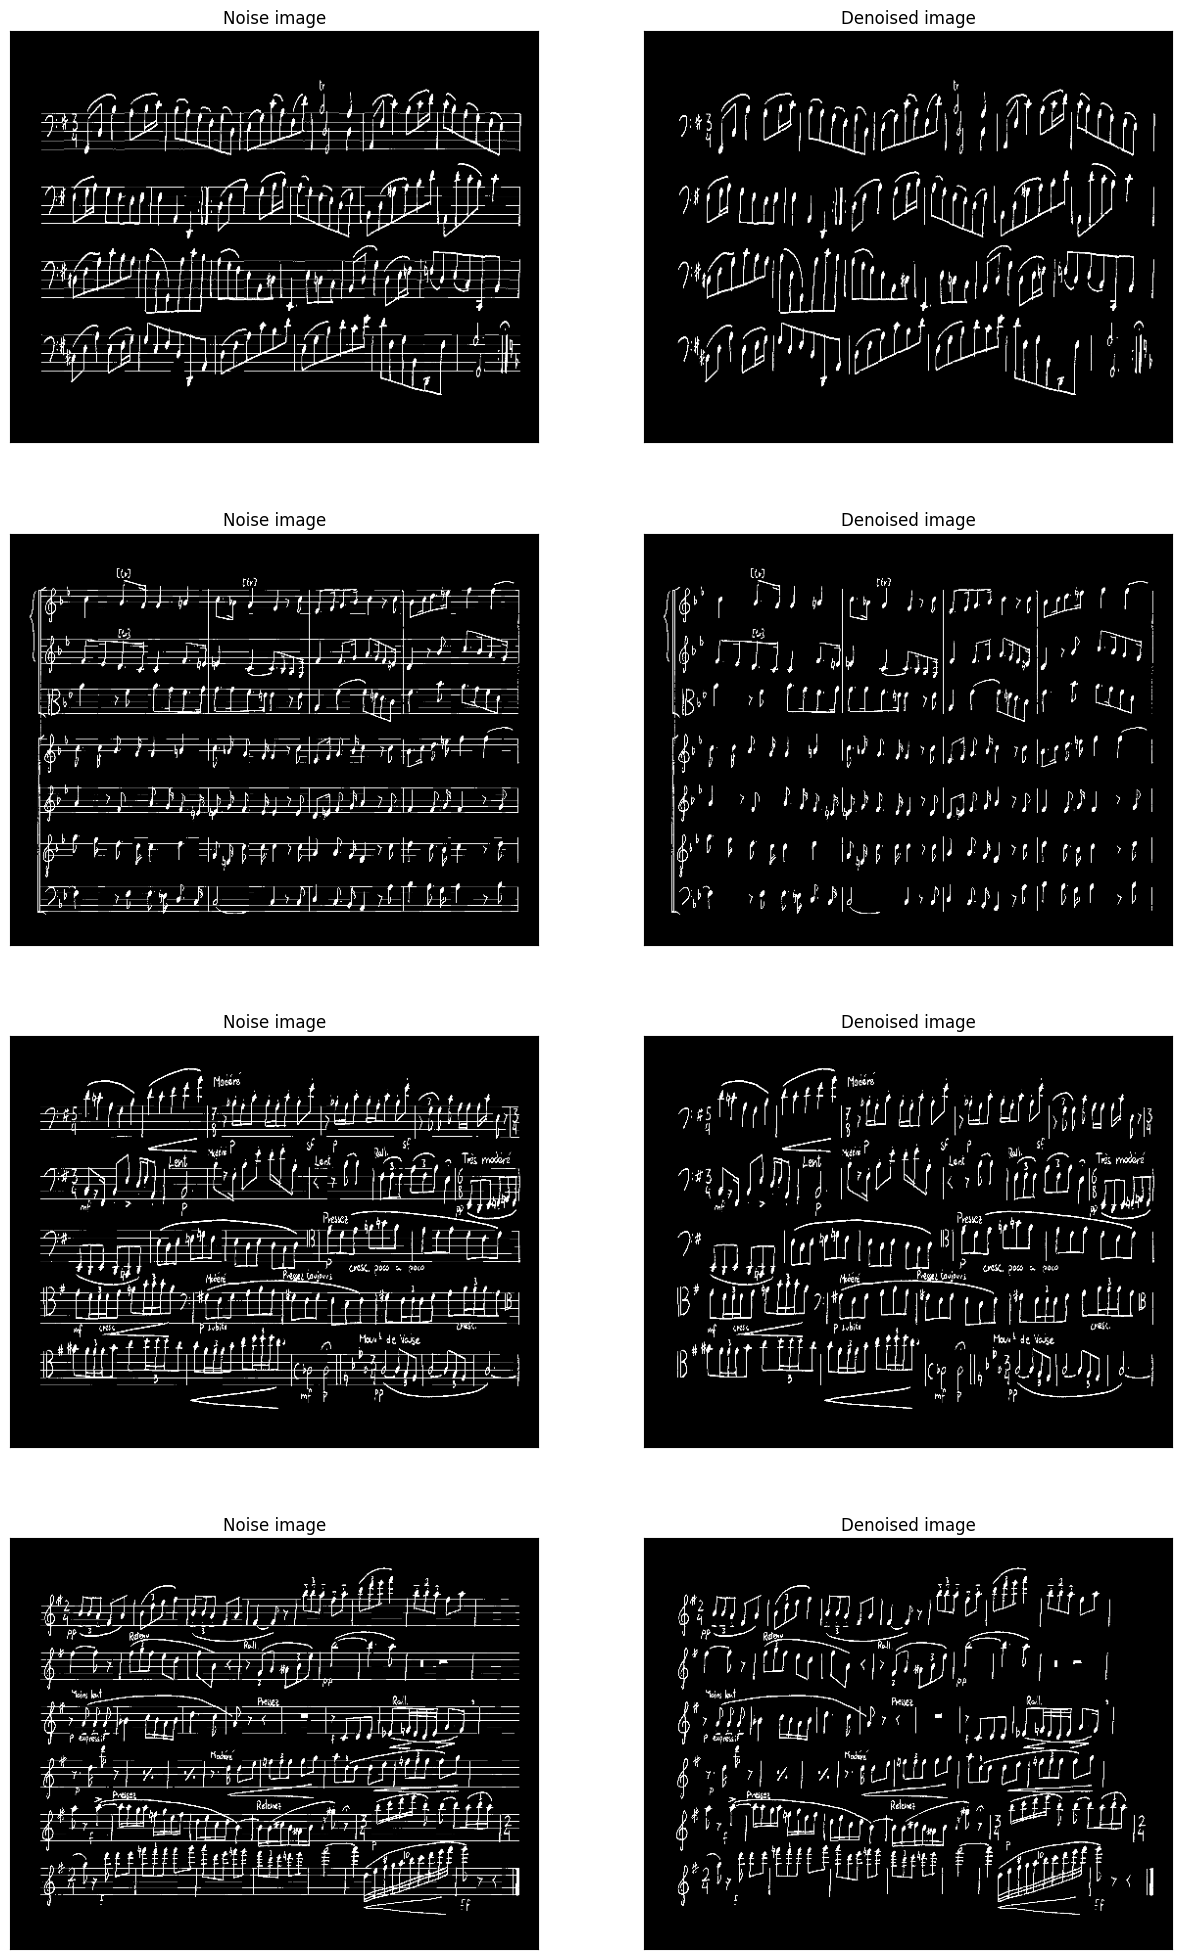

In [ ]:
# Visualize

plt.figure(figsize=(15,25))

for i in range(0, 8, 2):
    plt.subplot(4, 2, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(train[i][:,:,0], cmap='gray')
    plt.title('Noise image')
    
    plt.subplot(4,2,i+2)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(train_cleaned[i][:,:,0], cmap='gray')
    plt.title('Denoised image')

plt.show()

In [ ]:
# In this step we convert lists to numpy arrays and split dataset into train and validation in ration 85% train, 15% test.

# convert list to numpy array
X_train = np.asarray(train)
Y_train = np.asarray(train_cleaned)
X_test = np.asarray(test)

X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.15)
X_train.shape, X_val.shape, Y_train.shape, Y_val.shape

((850, 420, 540, 1),
 (150, 420, 540, 1),
 (850, 420, 540, 1),
 (150, 420, 540, 1))

In [ ]:
train, train_cleaned, test = None, None, None #To free up memory

In [ ]:
# Define the model

def model():
    input_layer = Input(shape=(420, 540, 1))
    
    # encoding
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(input_layer)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)

    x = MaxPooling2D((2, 2), padding='same')(x)
    
    x = Dropout(0.5)(x)

    # decoding
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)

    x = UpSampling2D((2, 2))(x)

    output_layer = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)
    model = Model(inputs=[input_layer], outputs=[output_layer])
    model.compile(optimizer='adam' , loss='mean_squared_error', metrics=['mae'])

    return model

model = model()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 420, 540, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 420, 540, 64)      640       
                                                                 
 conv2d_1 (Conv2D)           (None, 420, 540, 128)     73856     
                                                                 
 batch_normalization (BatchN  (None, 420, 540, 128)    512       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 210, 270, 128)    0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 210, 270, 128)     0     

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
Found GPU at: /device:GPU:0


In [ ]:
import time

In [ ]:
# Train Model

callback = EarlyStopping(monitor='loss', patience=30)

start = time.time()

with tf.device('/device:GPU:0'):
    history = model.fit(
        X_train, 
        Y_train, 
        validation_data = (X_val, Y_val), 
        epochs=100, 
        batch_size=12, 
        callbacks=[callback])
    
end = time.time()

Epoch 1/100
71/71 [==============================] - 112s 1s/step - loss: 0.0858 - mae: 0.1816 - val_loss: 0.0409 - val_mae: 0.0896
Epoch 2/100
71/71 [==============================] - 74s 1s/step - loss: 0.0238 - mae: 0.0821 - val_loss: 0.0420 - val_mae: 0.0577
Epoch 3/100
71/71 [==============================] - 74s 1s/step - loss: 0.0098 - mae: 0.0537 - val_loss: 0.0426 - val_mae: 0.0507
Epoch 4/100
71/71 [==============================] - 74s 1s/step - loss: 0.0054 - mae: 0.0317 - val_loss: 0.0421 - val_mae: 0.0508
Epoch 5/100
71/71 [==============================] - 74s 1s/step - loss: 0.0043 - mae: 0.0249 - val_loss: 0.0412 - val_mae: 0.0504
Epoch 6/100
71/71 [==============================] - 74s 1s/step - loss: 0.0037 - mae: 0.0207 - val_loss: 0.0392 - val_mae: 0.0488
Epoch 7/100
71/71 [==============================] - 74s 1s/step - loss: 0.0033 - mae: 0.0180 - val_loss: 0.0347 - val_mae: 0.0456
Epoch 8/100
71/71 [==============================] - 74s 1s/step - loss: 0.0031 - 

In [ ]:
print(end-start)

7483.198553085327


In [ ]:
X_train, X_val, Y_train, Y_val = None, None, None, None

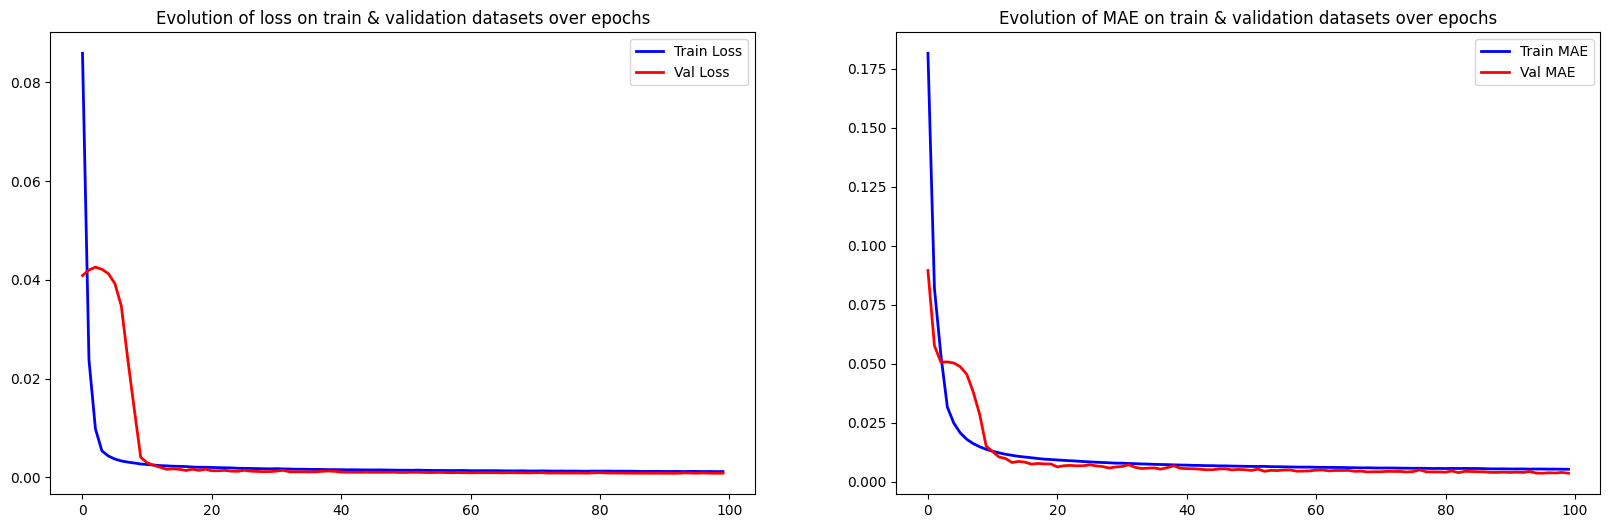

In [ ]:
# Plot error evolution on epochs

# Check how loss & mae went down
epoch_loss = history.history['loss']
epoch_val_loss = history.history['val_loss']
epoch_mae = history.history['mae']
epoch_val_mae = history.history['val_mae']

plt.figure(figsize=(20,6))
plt.subplot(1,2,1)
plt.plot(range(0,len(epoch_loss)), epoch_loss, 'b-', linewidth=2, label='Train Loss')
plt.plot(range(0,len(epoch_val_loss)), epoch_val_loss, 'r-', linewidth=2, label='Val Loss')
plt.title('Evolution of loss on train & validation datasets over epochs')
plt.legend(loc='best')

plt.subplot(1,2,2)
plt.plot(range(0,len(epoch_mae)), epoch_mae, 'b-', linewidth=2, label='Train MAE')
plt.plot(range(0,len(epoch_val_mae)), epoch_val_mae, 'r-', linewidth=2,label='Val MAE')
plt.title('Evolution of MAE on train & validation datasets over epochs')
plt.legend(loc='best')

plt.show()

In [ ]:
! pip install -q pyyaml h5py  # Required to save models in HDF5 format

In [ ]:
model.save('cvcMuscimaKerasModel.h5')

In [ ]:
# predict/clean test images
Y_test = model.predict(X_test, batch_size=1)

1000/1000 [==============================] - 16s 15ms/step


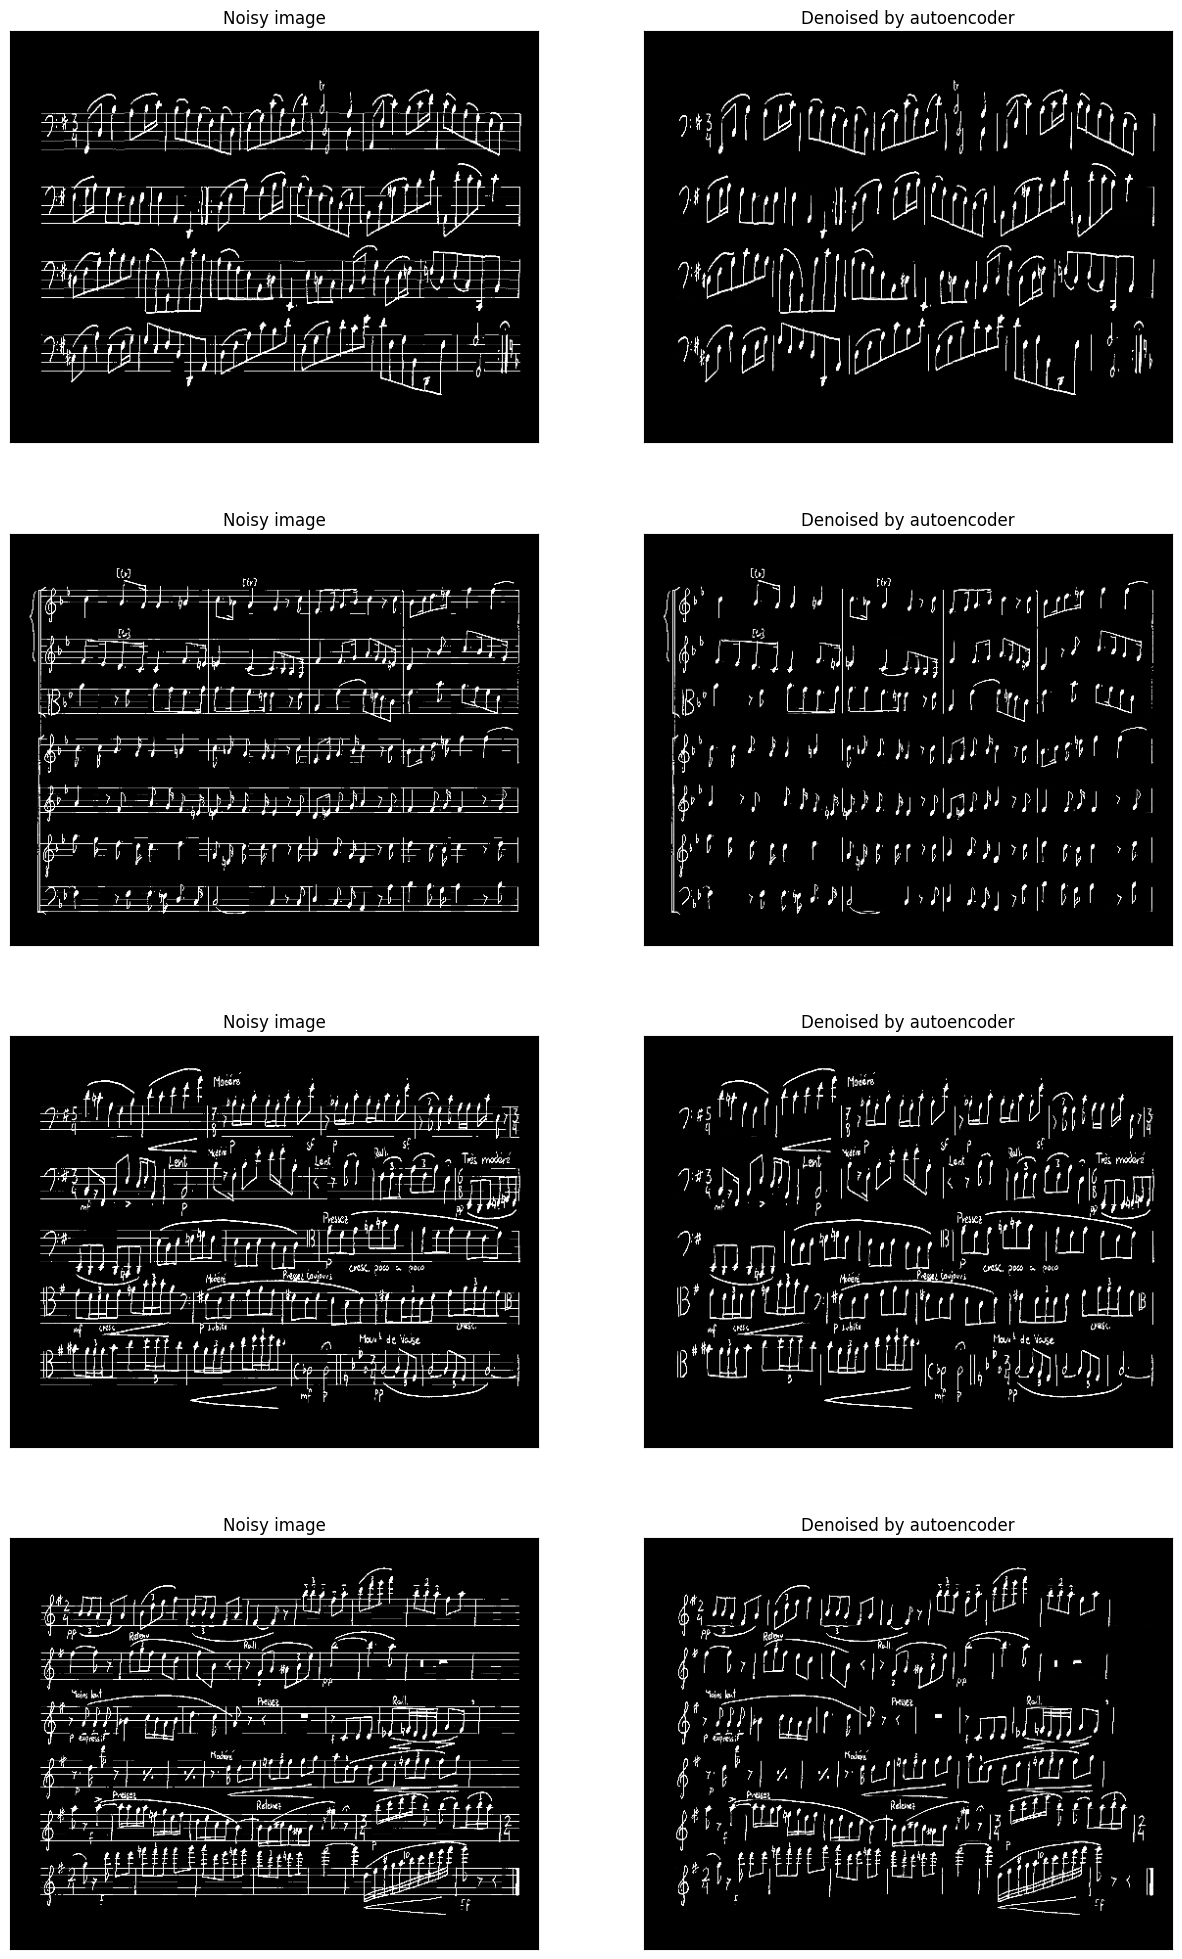

In [ ]:
plt.figure(figsize=(15,25))
for i in range(0,8,2):
    plt.subplot(4,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(X_test[i][:,:,0], cmap='gray')
    plt.title('Noisy image')
    
    plt.subplot(4,2,i+2)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(Y_test[i][:,:,0], cmap='gray')
    plt.title('Denoised by autoencoder')

plt.show()